<a href="https://colab.research.google.com/github/mocccca/cmor438/blob/main/Supervised%20Learning/K%20Nearest%20Neighbors/K_Nearest_Neighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Nearest Neighbors (KNN) for Regression and Classification

**K-Nearest Neighbors (KNN)** is a simple, instance-based learning algorithm used for both regression and classification.  
It makes predictions by looking at the `k` closest data points (neighbors) in the feature space.



## General Process

1. **Input**
   Dataset with predictors (`X`) and target (`y`).

2. **Define `k`**
   Choose the number of neighbors to consider (hyperparameter).

3. **Compute Distances**
   For a new observation, calculate the distance (usually Euclidean) to all points in the training set.

4. **Identify Nearest Neighbors**
   Select the `k` closest points.

5. **Make Prediction**
   - For regression: take the average (mean) of the `k` neighbors’ target values.
   - For classification: assign the most frequent class among the `k` neighbors.



## Advantages of KNN

- **Simple to Understand and Implement**
  No assumptions about data distribution.

- **Flexible**
  Can handle both regression and classification.

- **Nonparametric**
  No explicit training phase or model fitting; makes predictions directly from data.


## Disadvantages of KNN

- **Computationally Expensive**
  Prediction requires calculating distances to all training points.

- **Sensitive to Irrelevant Features**
  Performance can degrade if irrelevant or unscaled features dominate the distance metric.

- **Requires Careful `k` Selection**
  Too small `k` → noisy predictions; too large `k` → oversmoothing.

- **Curse of Dimensionality**
  Performance decreases as the number of features grows.


## Application 1: Regression

### Variables

- **Predictors (`X`):**
  - `emotional_exhaution_composite`
  - `procrastination_composite`
  - `workaholism_composite`
  - `neuroticism_composite`
  - `general_js_composite`
  - `global_js_composite`

- **Target (`y`):**
  - `depression_composite`

### Goal

Use **KNN Regression** to predict participants’ depression scores by averaging the depression values of the nearest participants with similar exhaustion, procrastination, workaholism, neuroticism, and job satisfaction profiles.


## Application 2: Classification

### Variables

- **Predictors (`X`):**
  - `age`
  - `ocb_composite` (organizational citizenship behavior)
  - `ip_realistic` (RIASEC realistic dimension)
  - `education_level`

- **Target (`y`):**
  - `org_status_3` (supervisory status)

### Goal

Use **KNN Classification** to predict whether a participant holds a supervisory position by majority vote among the closest participants with similar demographic, behavioral, and personality traits.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
class KNN:
    """
    A flexible K-Nearest Neighbors implementation for both classification and regression.

    Features:
    - Handles both continuous and binary target variables
    - Automatic distance metric (Euclidean)
    - Optimal k selection visualization
    - Standardization option
    """

    def __init__(self, k=5, regression=False, standardize=True):
        """
        Initialize KNN model.

        Args:
            k: Number of neighbors to consider
            regression: Whether to perform regression (True) or classification (False)
            standardize: Whether to standardize features (recommended for KNN)
        """
        self.k = k
        self.regression = regression
        self.standardize = standardize
        self.scaler = None
        self.X_train = None
        self.y_train = None

    def _distance(self, a, b):
        """Calculate Euclidean distance between two points"""
        return np.sqrt(np.sum((a - b) ** 2))

    def fit(self, X, y):
        """
        Store training data.

        Args:
            X: Feature matrix (n_samples, n_features)
            y: Target values (n_samples,)
        """
        if self.standardize:
            self.scaler = StandardScaler()
            self.X_train = self.scaler.fit_transform(X)
        else:
            self.X_train = X
        self.y_train = y

    def predict(self, X):
        """Predict target values for new data"""
        if self.standardize:
            X = self.scaler.transform(X)

        predictions = []
        for point in X:
            # Calculate distances to all training points
            distances = [self._distance(point, x) for x in self.X_train]

            # Get indices of k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]

            if self.regression:
                # For regression: return mean of neighbors
                predictions.append(np.mean(k_nearest_labels))
            else:
                # For classification: return most common class
                most_common = Counter(k_nearest_labels).most_common(1)
                predictions.append(most_common[0][0])

        return np.array(predictions)

    def evaluate(self, X_test, y_test):
        """Evaluate model performance on test data"""
        y_pred = self.predict(X_test)
        if self.regression:
            mse = mean_squared_error(y_test, y_pred)
            print(f"Mean Squared Error: {mse:.4f}")
            return mse
        else:
            acc = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {acc:.2%}")
            return acc

    def find_optimal_k(self, X_val, y_val, max_k=25):
        """
        Find optimal k value using validation data.

        Args:
            X_val: Validation features
            y_val: Validation targets
            max_k: Maximum k value to test

        Returns:
            Optimal k value
        """
        k_values = range(1, max_k+1, 2)
        errors = []

        for k in k_values:
            self.k = k
            if self.regression:
                error = mean_squared_error(y_val, self.predict(X_val))
            else:
                error = 1 - accuracy_score(y_val, self.predict(X_val))
            errors.append(error)

        optimal_k = k_values[np.argmin(errors)]

        plt.figure(figsize=(10, 6))
        plt.plot(k_values, errors, marker='o')
        plt.xlabel('k')
        plt.ylabel('Error' if self.regression else 'Classification Error')
        plt.title('Finding Optimal k')
        plt.xticks(k_values)
        plt.grid(True)
        plt.show()

        return optimal_k

predicting depression (regression example)

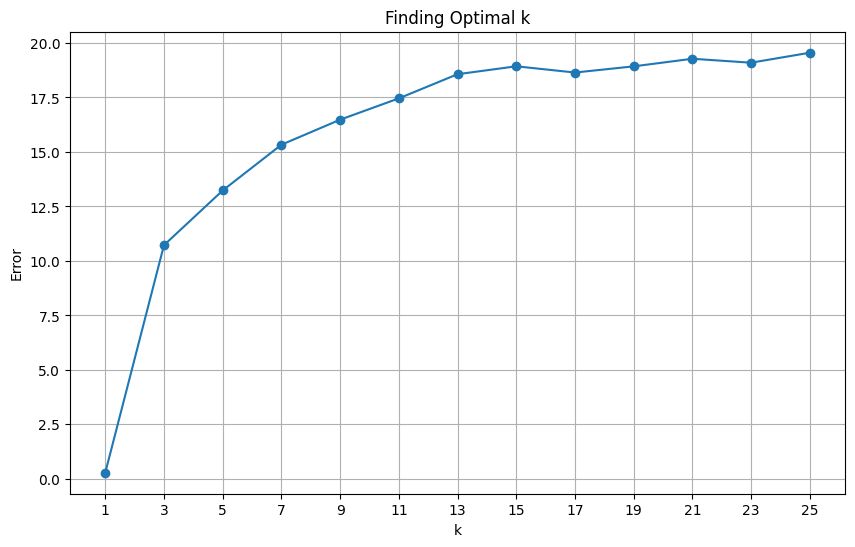

Optimal k: 1
Mean Squared Error: 34.2000
Predicted depression score: 14.0


In [ ]:
# import data
url = "https://raw.githubusercontent.com/mocccca/cmor438/main/Leisure_Intereset_Dataset.csv"
li = pd.read_csv(url)
li3 = li[['depression_composite', 'emotional_exhaution_composite', 'procrastination_composite']].copy()
li3

X = li3[['emotional_exhaution_composite', 'procrastination_composite']].values
y = li3['depression_composite'].values

# 3. Split data - ensuring we have enough samples
if len(X) > 10:  # Minimum samples needed
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    raise ValueError("Not enough samples for train-test split")

# 4. Initialize and train KNN regressor
knn_reg = KNN(k=5, regression=True, standardize=True)
knn_reg.fit(X_train, y_train)

# 5. Find optimal k - using training data for demonstration
# (Note: Should use validation set in practice)
optimal_k = knn_reg.find_optimal_k(X_train, y_train)  # Changed to X_train/y_train
print(f"Optimal k: {optimal_k}")

# 6. Evaluate on test set
knn_reg.k = optimal_k
test_mse = knn_reg.evaluate(X_test, y_test)

# 7. Make predictions - CORRECTED to match your 2 features
sample_prediction = knn_reg.predict(np.array([[25, 15]]))  # Only 2 features now
print(f"Predicted depression score: {sample_prediction[0]:.1f}")

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# After model training
y_pred = knn_reg.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"""
Regression Performance:
- MSE: {mse:.2f}
- RMSE: {rmse:.2f} (Interpret in your depression score units)
- MAE: {mae:.2f} (Average absolute error)
- R²: {r2:.2f} (1 = perfect fit)
""")

# Compare to baseline
baseline_pred = np.mean(y_train)
baseline_mse = mean_squared_error(y_test, [baseline_pred]*len(y_test))
print(f"Baseline MSE (predicting mean): {baseline_mse:.2f}")
print(f"Improvement over baseline: {(1 - mse/baseline_mse):.1%}")


Regression Performance:
- MSE: 34.20
- RMSE: 5.85 (Interpret in your depression score units)
- MAE: 4.44 (Average absolute error)
- R²: -0.15 (1 = perfect fit)

Baseline MSE (predicting mean): 30.05
Improvement over baseline: -13.8%


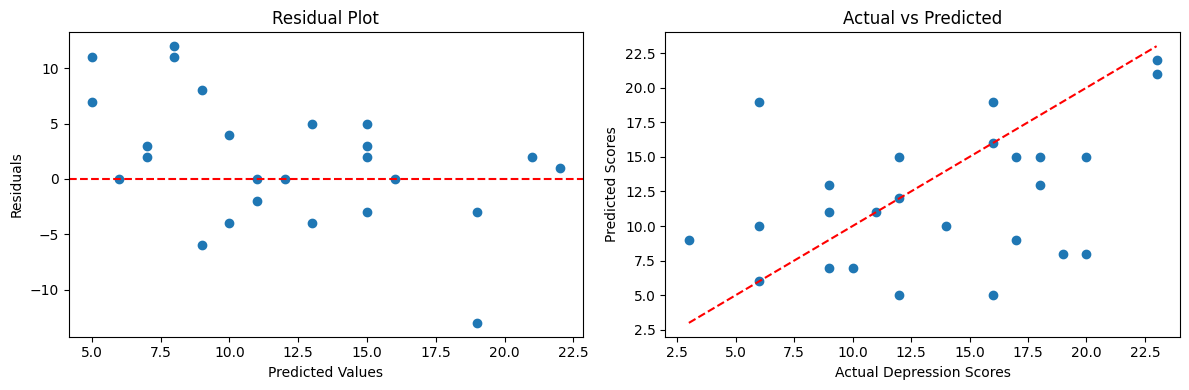

In [ ]:
plt.figure(figsize=(12, 4))

# Residual plot
plt.subplot(121)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Actual vs Predicted
plt.subplot(122)
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Depression Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted')

plt.tight_layout()
plt.show()

R^2 is relatively off, thus trying to add in more variables.

In [ ]:
# Create a fresh copy and reset indices
li5 = li[['depression_composite', 'emotional_exhaution_composite', 'procrastination_composite', 'workaholism_composite', 'neuroticism_composite', 'general_js_composite', 'global_js_composite']].copy()
li5

,depression_composite,emotional_exhaution_composite,procrastination_composite,workaholism_composite,neuroticism_composite,general_js_composite,global_js_composite
0,16,35,14,51,43,14,10
1,17,31,5,58,40,18,13
2,8,14,16,28,39,14,13
3,23,58,19,60,37,12,10
4,23,39,15,48,35,14,11
...,...,...,...,...,...,...,...
116,11,22,5,58,34,19,14
117,6,13,9,36,34,17,14
118,12,33,10,48,37,16,13
119,14,31,5,67,34,17,18


In [ ]:
# 2. Define features/target
X = li5[['emotional_exhaution_composite', 'procrastination_composite', 'workaholism_composite', 'neuroticism_composite', 'general_js_composite', 'global_js_composite']].values
y = li5['depression_composite'].values

# 3. Split FIRST, then scale
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Pass DataFrame (no .values yet)
    y,
    test_size=0.2,
    random_state=42
)

# 4. Scale AFTER splitting
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit ONLY on training data
X_test_scaled = scaler.transform(X_test)       # Transform test data

# Train and evaluate
knn_reg.fit(X_train_scaled, y_train)
y_pred = knn_reg.predict(X_test_scaled)
print(f"Enhanced R²: {r2_score(y_test, y_pred):.2f}")

Enhanced R²: 0.35


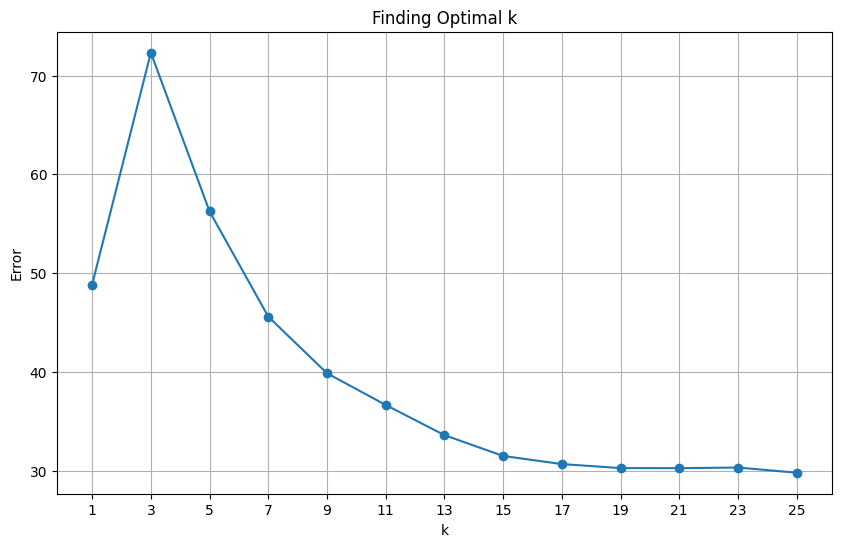

Optimal k: 25
Mean Squared Error: 32.9897


In [ ]:
# 5. Find optimal k - using training data for demonstration
# (Note: Should use validation set in practice)
optimal_k = knn_reg.find_optimal_k(X_train, y_train)  # Changed to X_train/y_train
print(f"Optimal k: {optimal_k}")

# 6. Evaluate on test set
knn_reg.k = optimal_k
test_mse = knn_reg.evaluate(X_test, y_test)

the results is not bad!

test classifier?

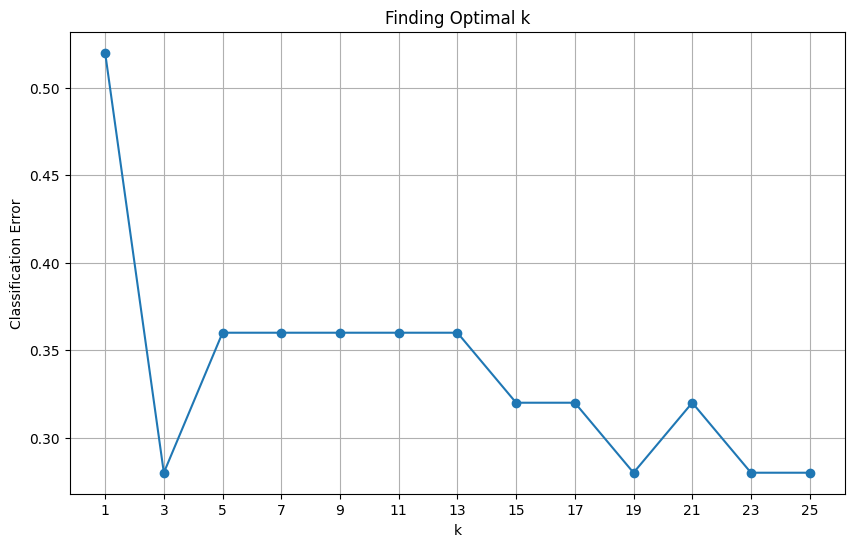

Optimal k: 3
Accuracy: 72.00%
Predicted supervision status: Yes


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# prepare data
li4 = li[['org_status_3', 'age', 'ocb_composite','education_level']].copy()

li4['ip_realistic'] = li['ipa_realistic'].combine_first(li['ipb_realistic'])

# Define ordered categories
education_levels = [
    "Less than high school",
    "High school degree",
    "Some college",
    "Associate degree",
    "Bachelor’s degree",
    "Master’s degree",
    "Professional degree",
    "Doctorate"
]

# Convert to ordered categorical (preserving original 1-8 codes)
li4['education_level'] = pd.Categorical(
    li4['education_level'],
    categories=[1, 2, 3, 4, 5, 6, 7, 8],  # Your original codes
    ordered=True
)

# Define variables
X = li4[['age', 'ocb_composite', 'ip_realistic','education_level']]
y = li4['org_status_3'].values  # supervise people


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train KNN classifier
knn_clf = KNN(k=5, regression=False, standardize=True)
knn_clf.fit(X_train, y_train)

# Find optimal k (optional)
optimal_k = knn_clf.find_optimal_k(X_test, y_test)
print(f"Optimal k: {optimal_k}")

# Evaluate
knn_clf.k = optimal_k  # Set to optimal k
test_acc = knn_clf.evaluate(X_test, y_test)

# Make predictions
sample_prediction = knn_clf.predict(np.array([[35, 50, 4, 3]]))
print(f"Predicted supervision status: {'Yes' if sample_prediction[0] == 1 else 'No'}")

In [ ]:
# evaluating the results
y_pred = knn_clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Full Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[11  3]
 [ 4  7]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.70      0.64      0.67        11

    accuracy                           0.72        25
   macro avg       0.72      0.71      0.71        25
weighted avg       0.72      0.72      0.72        25



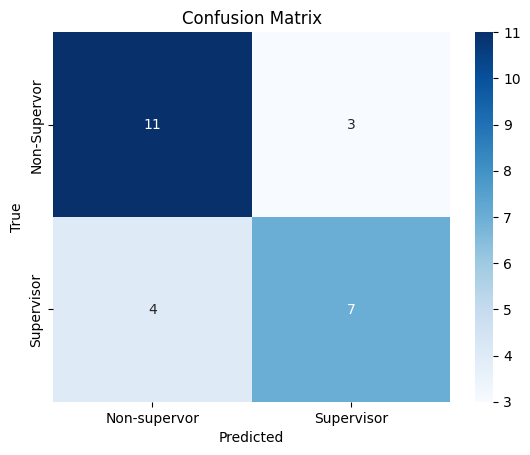

In [ ]:
# visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-supervor', 'Supervisor'],
            yticklabels=['Non-Supervor', 'Supervisor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

compared to logistics regression, KNN def pro